Please provide weights for MSFT, AAPL respectively, separated by commas (e.g. 0.4,0.3,0.3): 
[*********************100%%**********************]  2 of 2 completed
Missing Values Check:
open          aapl    0
              msft    0
high          aapl    0
              msft    0
low           aapl    0
              msft    0
close         aapl    0
              msft    0
adj close     aapl    0
              msft    0
volume        aapl    0
              msft    0
dividends             0
stock splits          0
dtype: int64
Outliers Check:
close has aapl    171
msft      0
dtype: int64 outliers.
volume has aapl    175
msft    141
dtype: int64 outliers.


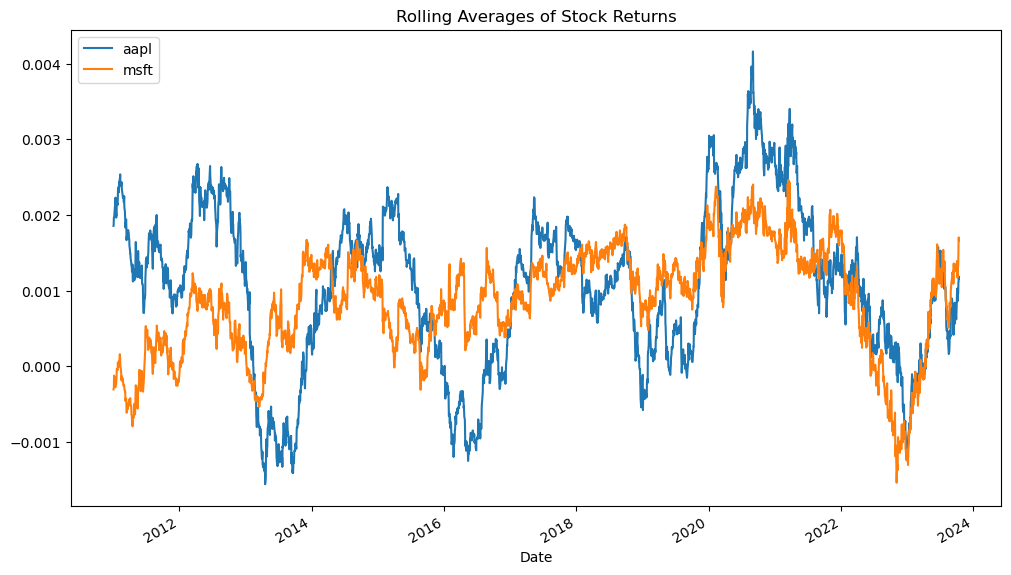

[*********************100%%**********************]  1 of 1 completed
Beta values relative to S&P 500:  {'msft': 1.1239300336147666, 'aapl': 1.1144213712991229}


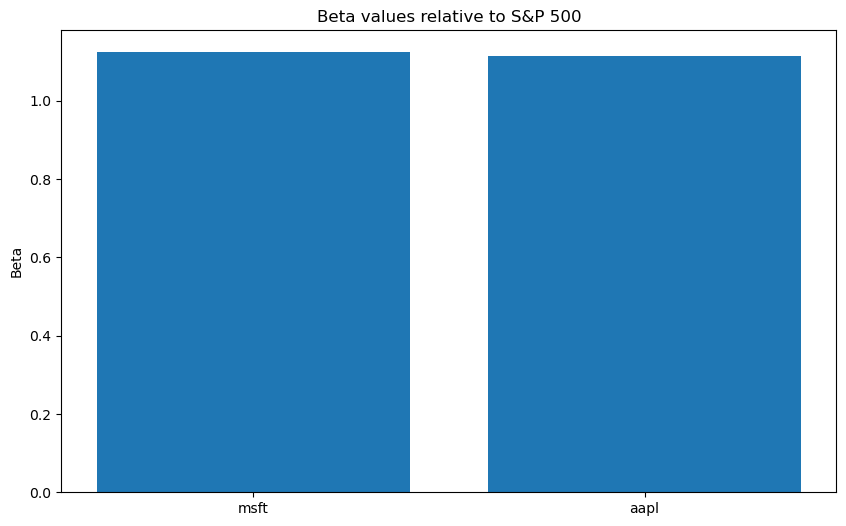

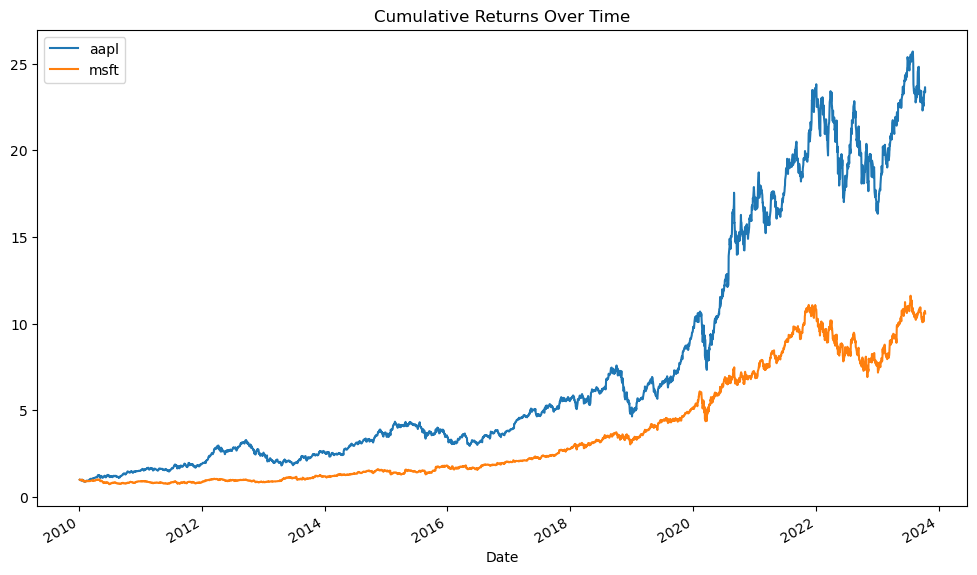

Diversification Ratio: 1.58
[*********************100%%**********************]  2 of 2 completed


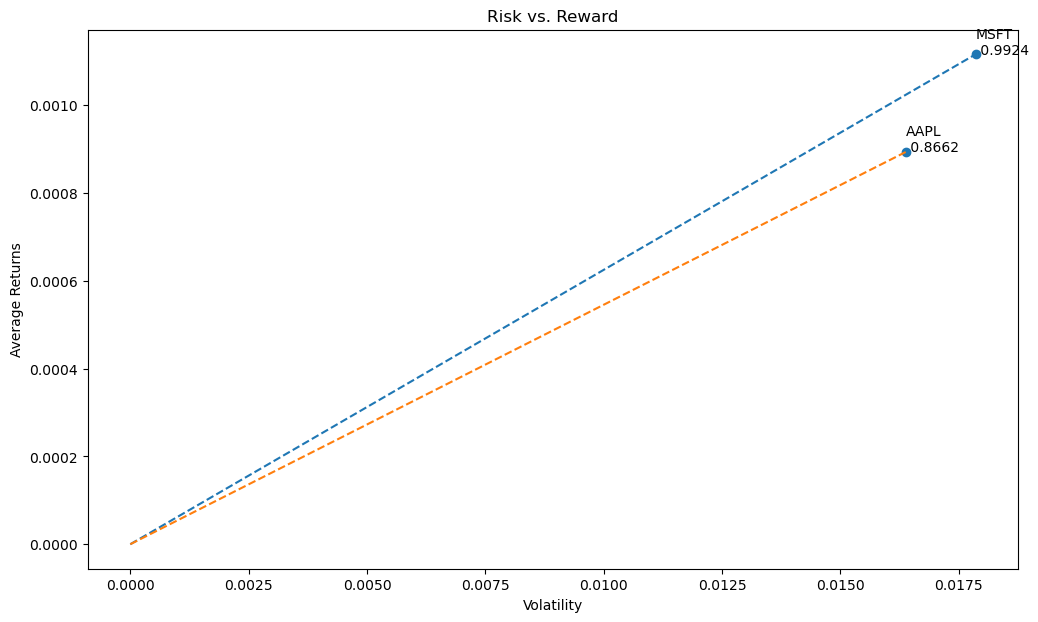


Historical Performance Analysis:

MSFT:
Mean Daily Return: 0.0009
Annualized Volatility: 0.2601
Sharpe Ratio: 0.8662
Sortino Ratio: 0.0807
Maximum Drawdown: -0.3715
Value at Risk (95% confidence): 0.0244
Earnings Per Share (EPS): 9.67
P/E Ratio: 34.40

AAPL:
Mean Daily Return: 0.0011
Annualized Volatility: 0.2835
Sharpe Ratio: 0.9924
Sortino Ratio: 0.0919
Maximum Drawdown: -0.4380
Value at Risk (95% confidence): 0.0268
Earnings Per Share (EPS): 5.96
P/E Ratio: 29.99
Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo sim

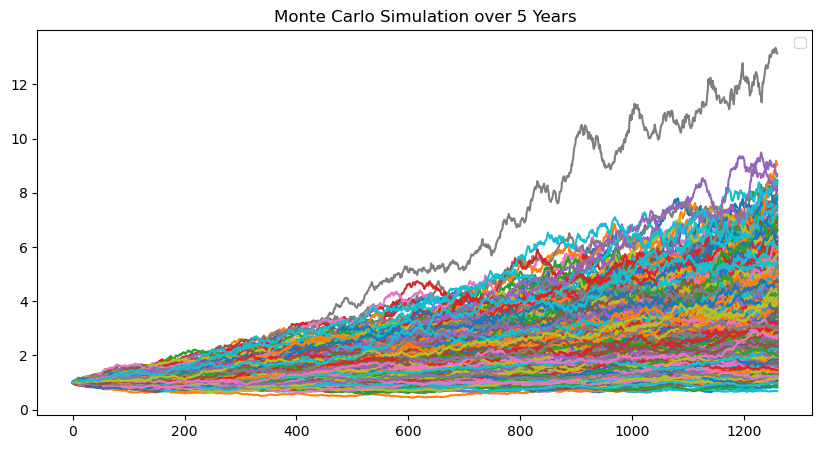

Confidence Interval (5th, 95th percentile): 
0.05    1.465825
0.95    6.074946
Name: 1260, dtype: float64


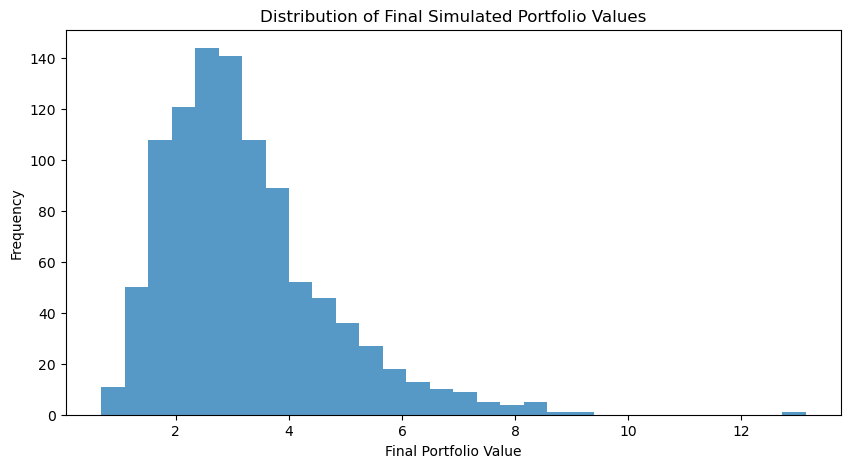

Optimized W.B Pct: ['66%', '34%']
Optimized Weight Breaks: [0.65962779 0.34037221]


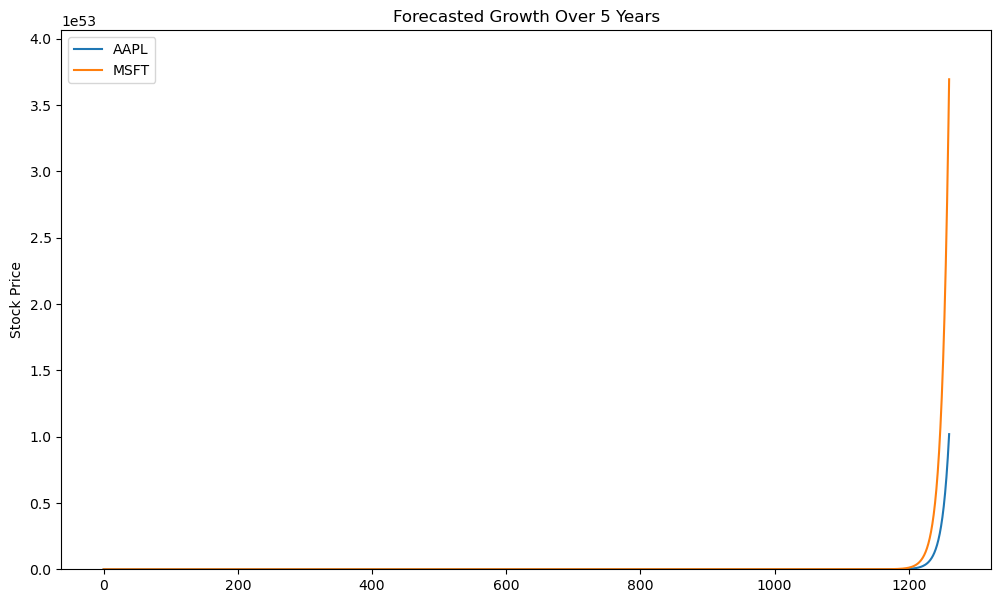

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from MCForecastTools import MCSimulation
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import minimize
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# 1. Data Fetching Enhancements:
def get_stock_data(tickers, start_date="2010-01-01", end_date=datetime.now().strftime('%Y-%m-%d')):
    try:
        stock_data = yf.download(tickers, start=start_date, end=end_date)
        required_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits']
        for col in required_columns:
            if col not in stock_data.columns:
                stock_data[col] = 0.0
                
        missing_tickers = [ticker for ticker in tickers if ticker not in stock_data.columns.get_level_values(1)]
        if missing_tickers:
            print(f"No data found for tickers: {', '.join(missing_tickers)}. Please check these tickers and try again.")
            return None
                
        if stock_data.empty:
            print("Some tickers returned no data. Please verify the tickers and try again.")
            return None
        return stock_data[required_columns]
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

def valid_tickers(tickers):
    for ticker in tickers:
        try:
            if yf.Ticker(ticker).info.get('sector', 'NaN') == 'NaN':
                print(f"Ticker {ticker} is invalid or not recognized.")
                return False
        except Exception as e:
            print(f"Error encountered for ticker {ticker}: {e}")
            return False
    return True

user_input = input("Please enter stock tickers separated by commas (e.g. AAPL,MSFT,GOOGL,TGT,PEP): ")
tickers = [x.strip().upper() for x in user_input.split(",")]

while not valid_tickers(tickers):
    print("One or more tickers are invalid. Please try again.")
    user_input = input("Please enter stock tickers separated by commas (e.g. AAPL,MSFT,GOOGL,TGT,PEP): ")
    tickers = [x.strip().upper() for x in user_input.split(",")]

print(f"Please provide weights for {', '.join(tickers)} respectively, separated by commas (e.g. 0.4,0.3,0.3): ")
weights_input = input().split(',')
weights = [float(x.strip()) for x in weights_input]

while not (0.99 <= sum(weights) <= 1.01):
    print("Weights do not sum up to 1. Please try again.")
    print(f"Please provide weights for {', '.join(tickers)} respectively, separated by commas: ")
    weights_input = input().split(',')
    weights = [float(x.strip()) for x in weights_input] #

user_input_years = input("Please enter the number of years for the simulation (1, 2, 3, 4, or 5): ")
while user_input_years not in ["1", "2", "3", "4", "5"]:
    print("Invalid input. Please enter 3, 4, or 5.")
    user_input_years = input("Please enter the number of years for the simulation (1, 2, 3, 4, or 5): ")

num_years = int(user_input_years)

def check_missing_values(data):
    missing = data.isnull().sum()
    print("Missing Values Check:")
    print(missing)

def check_outliers(data, columns_to_check):
    print("Outliers Check:")
    for column in columns_to_check:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR)))
        print(f"{column} has {outliers.sum()} outliers.")

portfolio_data = get_stock_data(tickers)
initial_values = portfolio_data.xs('Adj Close', level=0, axis=1).iloc[0]
portfolio_data.columns = pd.MultiIndex.from_tuples([(x[0].lower(), x[1].lower()) for x in portfolio_data.columns])
# This function checks for missing values in the data
check_missing_values(portfolio_data)
check_outliers(portfolio_data, columns_to_check=['close', 'volume'])
# Handling missing values
returns = portfolio_data.xs('close', level=0, axis=1).pct_change().apply(lambda x: x.dropna() if x.isnull().sum() > 0 else x)   



# Calculate and plot the rolling averages
rolling_windows = [252]  # Added the 252-day (1-year) rolling average as recommended
plt.figure(figsize=(12, 7))

for window in rolling_windows:
    rolling_mean = returns.rolling(window=window).mean()
    rolling_mean.plot(ax=plt.gca(), label=f'{window}-Day Avg')

plt.title("Rolling Averages of Stock Returns")
plt.legend(loc="upper left")
plt.show()

# Fetching S&P 500 data
sp500_data = yf.download('^GSPC', start="2010-01-01", end=datetime.now().strftime('%Y-%m-%d'))['Adj Close']
sp500_returns = sp500_data.pct_change().dropna()

# Merging S&P 500 returns with your portfolio returns
all_returns = returns.join(sp500_returns.rename('sp500'))

# Calculating covariance matrix
cov_matrix = all_returns.cov()

# Beta calculation
beta = {}
for ticker in tickers:
    ticker_lower = ticker.lower()
    if ticker_lower in cov_matrix:
        beta[ticker_lower] = cov_matrix.loc[ticker_lower, 'sp500'] / cov_matrix.loc['sp500', 'sp500']
    else:
        print(f"{ticker} not found in covariance matrix.")
print("Beta values relative to S&P 500: ", beta)


# Plotting
plt.figure(figsize=(10,6))
plt.bar(beta.keys(), beta.values())
plt.title('Beta values relative to S&P 500')
plt.ylabel('Beta')
plt.show()

# After the beta calculation
cumulative_returns = (1 + returns).cumprod()
plt.figure(figsize=(12, 7))
cumulative_returns.plot(ax=plt.gca(), title="Cumulative Returns Over Time")
plt.legend(loc="upper left")
plt.show()


# After the Risk vs. Reward plot
portfolio_volatility = np.sqrt(np.dot(np.array(weights) ** 2, np.dot(returns.cov() * 252, weights)))
average_volatility = (returns.std() * np.sqrt(252)).mean()
diversification_ratio = average_volatility / portfolio_volatility


# Risk Analysis Enhancements:
def sortino_ratio(returns, target_return=0):
    excess_return = returns - target_return
    downside_std = np.sqrt(np.mean(np.minimum(excess_return, 0) ** 2))
    return np.mean(excess_return) / downside_std

def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    max_return = cumulative_returns.expanding().max()
    drawdown = cumulative_returns / max_return - 1
    return drawdown.min()

def value_at_risk(returns, confidence_level=0.95):
    return -np.percentile(returns, 100 - confidence_level * 100)

def fetch_pe_ratio(ticker):
    try:
        return yf.Ticker(ticker).info['trailingPE']
    except:
        return None
def fetch_eps(ticker):
    try:
        return yf.Ticker(ticker).info['trailingEps']
    except:
        return None
def historical_performance_analysis(tickers):
    data = get_stock_data(tickers)
    if data is None:
        return
    returns = data['Adj Close'].pct_change().dropna()  # Use 'Adj Close' for returns
    

    
    # Calculate metrics
    mean_daily_returns = returns.mean()
    volatility = returns.std()
    sharpe_ratio = np.sqrt(252) * (mean_daily_returns / volatility)
    
    #Ploting Sharpe ratio (Average_return Graph)

    plt.figure(figsize=(12, 7))
    plt.scatter(volatility, mean_daily_returns, marker='o')
    for i, txt in enumerate(tickers):
        plt.annotate(f'{txt}\n {sharpe_ratio.iloc[i]:.4f}', (volatility.iloc[i], mean_daily_returns.iloc[i]))
        plt.plot([0, volatility.iloc[i]], [0, mean_daily_returns.iloc[i]], linestyle='--')

    plt.xlabel('Volatility')
    plt.ylabel('Average Returns')
    plt.title('Risk vs. Reward')
    plt.show()

    # Display metrics
    print("\nHistorical Performance Analysis:")
    for ticker in tickers:
        print(f"\n{ticker}:")
        print(f"Mean Daily Return: {mean_daily_returns[ticker]:.4f}")
        print(f"Annualized Volatility: {volatility[ticker] * np.sqrt(252):.4f}")
        print(f"Sharpe Ratio: {sharpe_ratio[ticker]:.4f}")
        print(f"Sortino Ratio: {sortino_ratio(returns[ticker]):.4f}")
        print(f"Maximum Drawdown: {max_drawdown(returns[ticker]):.4f}")
        print(f"Value at Risk (95% confidence): {value_at_risk(returns[ticker]):.4f}")
        eps = fetch_eps(ticker)
        if eps:
            print(f"Earnings Per Share (EPS): {eps:.2f}")
        else:
            print("Earnings Per Share (EPS): Data not available")
        # Fundamental Analysis Enhancements:
        pe_ratio = fetch_pe_ratio(ticker)
        if pe_ratio:
            print(f"P/E Ratio: {pe_ratio:.2f}")
        else:
            print("P/E Ratio: Data not available")

# After the tickers are validated and before the Monte Carlo simulation
print(f"Diversification Ratio: {diversification_ratio:.2f}")
historical_performance_analysis(tickers)


# Transform the multi-indexed data into a single indexed dataframe for MCSimulation
mc_data = portfolio_data.xs('close', level=0, axis=1)
# Convert the single-indexed data back to a multi-indexed format
mc_data_multi = pd.concat([mc_data], keys=['close'], axis=1)
mc_data_multi = mc_data_multi.swaplevel(i=0, j=1, axis=1)

# Monte Carlo Simulation
mc_sim = MCSimulation(portfolio_data=mc_data_multi, weights=weights, num_simulation=10000, num_trading_days=252*num_years)

mc_sim.calc_cumulative_return()


# Monte Carlo Simulation Plot using Matplotlib
plt.figure(figsize=(10,5))
plt.plot(mc_sim.simulated_return)
plt.title(f"Monte Carlo Simulation over {num_years} Years")
plt.legend([])  # Hide legend
plt.show()


# After the Monte Carlo Simulation plot
confidence_interval = mc_sim.simulated_return.iloc[-1].quantile(q=[0.05, 0.95])
print(f"Confidence Interval (5th, 95th percentile): \n{confidence_interval}")


# Histogram of final simulated values
final_simulated_values = mc_sim.simulated_return.iloc[-1]
plt.figure(figsize=(10,5))
plt.hist(final_simulated_values, bins=30, alpha=0.75)
plt.title("Distribution of Final Simulated Portfolio Values")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.show()

# Calculate the average growth per day from the Monte Carlo simulations
average_daily_growth = mc_sim.simulated_return.mean(axis=1)

# To prevent overflow, cap the growth to a maximum of, say, 10% per day
average_daily_growth = average_daily_growth.clip(upper=0.1)

# Calculate the cumulative product of the average daily growth
cumulative_growth = (1 + average_daily_growth).cumprod()

# Project the growth of the initial values over the simulation period for each stock
forecasted_prices_each_stock = pd.DataFrame(index=cumulative_growth.index)

for stock in initial_values.index:
    forecasted_prices_each_stock[stock] = initial_values[stock] * cumulative_growth

#Weights optimization
def objective(weights): #portfolio optimization
    weights = np.array(weights)
    return - np.sum(returns.mean() * weights) / np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
result = minimize(objective, [1./len(tickers)]*len(tickers), method='SLSQP', bounds=[(0, 1) for _ in range(len(tickers))], constraints=constraints)
optimized_weights = result.x
formatted_weights = [f'{round(weight * 100)}%' for weight in optimized_weights]
print(f'Optimized W.B Pct: {formatted_weights}')
print(f"Optimized Weight Breaks: {result.x.round(10)}")


# Plot the forecasted growth for each stock
plt.figure(figsize=(12,7))
forecasted_prices_each_stock.plot(ax=plt.gca())
plt.title(f"Forecasted Growth Over {num_years} Years")
plt.ylabel("Stock Price")
plt.ylim(0, forecasted_prices_each_stock.max().max() * 1.1)  # Cap the y-axis to 110% of the max value
plt.show()

